<center> <h1><b>Quera-Connect: Data (Footballers)</b></h1> </center>

This notebook, which uses the `scikit-learn` library in Python, was prepared to present a possible solution of the [Quera-Connect: Data (Footballers)](https://quera.ir/contest/assignments/28792/problems) contest in the post-webinar hold on May 21, 2021. One can access the recorded webinar on [here](https://www.aparat.com/v/LyM5E). 

For any questions regarding this notebook, you can contact us from [here](mailto:hadisotudeh1992@gmail.com).
</br>
</br>
First, we need to import the relevant libraries, download the dataset, and have them available in Google Colab.

P.S. It is highly recommended to enable `GPU` on this notebook for quick computations.

## **Install & import libraries and download datasets**

In [ ]:
%%capture
# Remove previous files
! rm -rf sample_data
! rm train.csv test.csv *.joblib
! rm *.py && rm -rf sample_data && rm -rf sample-data

# Download the datasets (ShotData.csv and metrica matches)
! wget https://www.dropbox.com/s/w4n7n6gym6lvtq3/train.csv
! wget https://www.dropbox.com/s/e99qn1mmm7q6tk8/test.csv
! git clone https://github.com/metrica-sports/sample-data

# Clone required functions to read metrica data from LaurieOnTracking repository (Friends of Tracking)
! git clone https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking
! mv LaurieOnTracking/Metrica_IO.py ./Metrica_IO.py && mv LaurieOnTracking/Metrica_Viz.py ./Metrica_Viz.py
! rm -rf LaurieOnTracking

In [ ]:
# Import Libraries
# General libraries
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import numpy as np
import itertools
import warnings
import math
import os


# Machine learning libraries
from sklearn.metrics import plot_roc_curve, roc_auc_score, brier_score_loss
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import joblib

# Model interpretation library
from sklearn.inspection import plot_partial_dependence

# Metrica functions
import Metrica_IO as mio
import Metrica_Viz as mviz

## **Set Global Parameters**

In [ ]:
# Show plots inside the jupyter notebook
%matplotlib inline

# Pandas settings to show more columns are rows in the jupyter notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50000)

# Increase font size of the plots 
plt.rcParams.update({'font.size': 18})

# Don't show warnings
warnings.filterwarnings('ignore')

# Datasets
train_dataset = "train.csv"
test_dataset = "test.csv"

# Target variable to predict
dep_var = "outcome"

# Hyper-paramter tuning variables
cv = 5
seed = 42
scoring = 'roc_auc'

######### This part is copied from https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking/blob/master/Tutorial1_GettingStarted.py
# Set up initial path to data
DATADIR = './sample-data/data/'
game_id = 2 # let's look at sample match 2

home_team = "Home"
away_team =  "Away"

pitch_x = 105.
pitch_y = 68.

meters_per_yard = 0.9144 # unit conversion from yards to meters
goal_line_width = 8*meters_per_yard

#**Step 1 - Explore the dataset**


In [ ]:
df = pd.read_csv(train_dataset)
df.head()

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome
0,m_91,p_103,جریان بازی,پای راست,13.47,-11.22,1,0,متوسط,70,9,گُل
1,m_17,p_16,جریان بازی,پای چپ,9.48,14.22,3,0,متوسط,55,4,مهار توسط دروازه بان
2,m_111,p_88,ضربه آزاد مستقیم,پای چپ,29.43,-1.25,6,2,کم,86,31,مهار توسط دروازه بان
3,m_142,p_87,جریان بازی,پای راست,26.93,1.00,4,1,متوسط,77,2,موقعیت از دست رفته
4,m_117,p_9,جریان بازی,پای راست,10.72,5.24,2,0,متوسط,76,46,گُل


In [ ]:
# Q1: Number of Players

df.playerId.nunique()

160

In [ ]:
# Q2: Top Goal Scorer

df['label'] = df['outcome'].apply(lambda r: 1 if r == "گُل" else 0)
df.groupby('playerId')['label'].sum().nlargest(3)

playerId
p_18     16
p_6      14
p_105    12
Name: label, dtype: int64

In [ ]:
# Q3: Goal Scoring Rate

df.groupby(['playerId'])['label'].mean().nlargest(3)

playerId
p_18    0.253968
p_44    0.224490
p_6     0.218750
Name: label, dtype: float64

In [ ]:
df.groupby(['playerId'])['label'].mean().nsmallest(3)

playerId
p_147    0.028986
p_141    0.033333
p_151    0.037037
Name: label, dtype: float64

In [ ]:
# Q4: Maximum Distance

df['distance'] = df.apply(lambda r: int(math.sqrt(r.x**2 + r.y**2)) , axis=1)
df.sort_values(by=['distance'],ascending=False).head()[['playerId','distance']]

,playerId,distance
7013,p_30,71
4432,p_99,64
6974,p_113,60
3031,p_2,59
1666,p_159,58


#**Step 2 - Build an Expected Goal (xG) model**


## Load ShotData and Perform Data Cleaning & Feature Engineering

In [ ]:
def pre_process(df):
  """This function pre-processes the data to make it ready for the next steps of the pipeline"""

  # Column preprocessing
  # Binarize dep_var (goal and non-goal), binarize body type (foot and header)
  df["bodyPart"] = df["bodyPart"].apply(lambda r: "پا" if r in ["پای چپ", "پای راست"] else r) # goal = 1 and else 0

  # Calculate extra relevant features such as distance and angle

  # Euclidean distance to center of the goal sqrt(x^2+y^2)
  df["distance"] = np.sqrt(df["x"]**2 + df["y"]**2)

  # Shot angle ot the goal
  # The angle is arctan(goal_line_width*x/(x^2+y^2-(goal_line_width*/2)^2)), which is in radius and I convert it into degrees next
  df["angle"] = np.arctan(goal_line_width*df["x"]/(df["x"]**2+df["y"]**2-(goal_line_width/2)**2))
  df["angle"] = np.rad2deg(df["angle"].apply(lambda alpha: np.pi + alpha if alpha < 0 else alpha))

  # Rounding the dataframe (2 decimals)
  df = df.round(2)

  # Perform one-hot encoding without multicollinearity
  columns_to_encode = ["playType","bodyPart","interferenceOnShooter"]
  for col in columns_to_encode:
    # Prevent multicollinearity
    one_hot = pd.get_dummies(df[col], drop_first=True)
    # Drop the column as it is now encoded
    df = df.drop(col,axis = 1)
    # Join the encoded df
    df = df.join(one_hot)

  # Move outcome to the last column if it exists
  if dep_var in df.columns:
    features = [x for x in df.columns if x not in ["x","y",dep_var]]
    df = df[features + [dep_var]]
  else:
    features = [x for x in df.columns if x not in ["x","y"]]
    df = df[features]

  return df


# Keep only relevant features and the label (dep_var)
features = ["x","y","playType","bodyPart","interveningOpponents","interveningTeammates","interferenceOnShooter"]

# Read the train file
df = pd.read_csv(train_dataset).pipe(pre_process)

features = df.columns.tolist()
cols_to_remove = ["matchId","playerId","minute","second",dep_var]
for col in cols_to_remove:
  features.remove(col)

test_df = pd.read_csv(test_dataset).pipe(pre_process)

df.head()

,matchId,playerId,interveningOpponents,interveningTeammates,minute,second,distance,angle,ضربه آزاد مستقیم,مستقیم از کرنر,پنالتی,سر,پا,متوسط,کم,outcome
0,m_91,p_103,1,0,70,9,17.53,18.53,0,0,0,0,1,1,0,گُل
1,m_17,p_16,3,0,55,4,17.09,13.97,0,0,0,0,1,1,0,مهار توسط دروازه بان
2,m_111,p_88,6,2,86,31,29.46,14.14,1,0,0,0,1,0,1,مهار توسط دروازه بان
3,m_142,p_87,4,1,77,2,26.95,15.45,0,0,0,0,1,1,0,موقعیت از دست رفته
4,m_117,p_9,2,0,76,46,11.93,31.30,0,0,0,0,1,1,0,گُل


Check basic dataset statistics:

In [ ]:
print(f"There are {df.shape[0]} instances in the dataset.")

Is there any empty values in the dataset? No

There are 8925 instances in the dataset.


Binarize outcome (goals vs. non-goals) and name it `goal`(0 or 1) and print the binarized distribution.

In [ ]:
df["outcome"] = df["outcome"].apply(lambda r: 1 if r in ["گُل", "گُل به خودی"] else 0) # goal = 1 and else 0

# Change column name from outcome to isGoal
dep_var = "isGoal"
df = df.rename(columns={"outcome": dep_var})

distributions = df[dep_var].value_counts(normalize=True)
print(f"Non-Goal percentage is {round(100*distributions[0],2)}% and the Goal percentage is {round(100*distributions[1],2)}%")

Non-Goal percentage is 87.51% and the Goal percentage is 12.49%


Create Train and validation sets with (80%, 20%)

In [ ]:
# Selecting correspondnig columns for training and test stes

X = df[features].values
y = df[dep_var].values

# Spliting train and test sets. 80% for the training and 20% for the test set.
xs, valid_xs, y, valid_y = train_test_split(X, y, test_size=0.20, random_state=seed, shuffle=True)

## Define the evaluation metric, train ML Models, and choose the best one

Define [AUC ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) as the evaluation metric because the dataset is imbalanced.

In [ ]:
def calc_auc_roc(y, prob_pred):
  return roc_auc_score(y, prob_pred)

Now, it is time to do the hyper-parameter tuning

In [ ]:
## Hyperparameters

lr_hyperparameters = {
    'lr__C': [0.01, 0.1, 1.0, 10, 100]
}

rf_hyperparameters = {
    'rf__n_estimators': np.arange(20,100,10),
    'rf__max_features': np.arange(0.5,1.0,0.1),
    'rf__max_depth': np.arange(1,20,5),
}

xgb_hyperparameters = {
    'xgb__max_depth': np.arange(2,12,2),  # the maximum depth of each tree
    'xgb__learning_rate': [0.1,0.3],  # the training step for each iteration
    'xgb__n_estimators': np.arange(1,80,10),
}

lgbm_hyperparameters = {
    'lgbm__n_estimators': np.arange(10,140,20),
    'lgbm__min_data_in_leaf': np.arange(100,1000,100),
    'lgbm__max_depth': np.arange(2,10,2),

}

hyperparameters = {
    'lr': lr_hyperparameters,
    'rf': rf_hyperparameters,
    'lgbm': lgbm_hyperparameters,
    'xgb': xgb_hyperparameters,
}

# Pipeline of ML classiferis' pipielines 
pipelines = {
    'bl': Pipeline([('bl', DummyClassifier(strategy='most_frequent'))]), # base line
    'lr': Pipeline([('lr',LogisticRegression(random_state=seed, n_jobs=-1, penalty='l2'))]),
    'rf': Pipeline([('rf', RandomForestClassifier(random_state=seed, n_jobs=-1, oob_score=True))]),
    'xgb': Pipeline([('xgb', XGBClassifier(random_state=seed, n_jobs=-1))]),
    'lgbm': Pipeline([('lgbm', LGBMClassifier(random_state=seed, n_jobs=-1))]),
}

,model,training (auc roc),validation (auc roc),Brier score
0,Baseline,0.500,0.500,0.127
1,Logistic Regression,0.803,0.801,0.088
2,Random Forest,0.847,0.794,0.088
3,XGBoost,0.844,0.797,0.088
4,Light Gradient Boosting,0.832,0.794,0.088


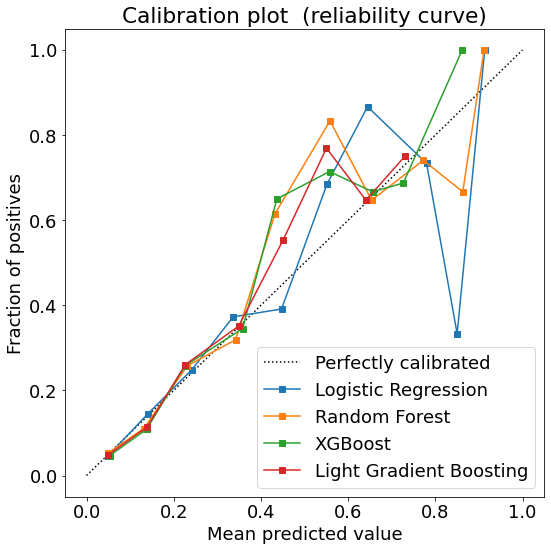

In [ ]:
# Start the training process

results = []
model_names = {"bl":"Baseline", "lr": "Logistic Regression" , "rf":"Random Forest", 
               "xgb": "XGBoost", "lgbm": "Light Gradient Boosting"}

fig, ax =  plt.subplots(figsize=(8, 8))
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for key, pipeline in tqdm(pipelines.items()):
  if key == 'bl':
      model = pipeline
  else:
      model = GridSearchCV(pipeline, hyperparameters[key], cv=cv, scoring=scoring, n_jobs=-1)

  model.fit(xs,y)

  if hasattr(model,'best_estimator_'):
      best = model.best_estimator_.named_steps[key]
  else:
      best = model

  result = {}

  result["model"] = model_names[key]

  train_prob_pred = best.predict_proba(xs)[:,1]

  result["training (auc roc)"] = calc_auc_roc(y, train_prob_pred)
  
  validation_prob_pred = best.predict_proba(valid_xs)[:,1]

  result["validation (auc roc)"]  = calc_auc_roc(valid_y, validation_prob_pred)


  fraction_of_positives, mean_predicted_value = calibration_curve(valid_y, validation_prob_pred, n_bins=10)

  result["Brier score"] = brier_score_loss(valid_y, validation_prob_pred)

  results.append(result)

  # Do not log calibration information for baseline fitter, as I already have done it.
  if key == 'bl':
    continue

  # Plot the calibration plot  
  ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % (model_names[key], ))
    
  # Save the model
  joblib.dump(best, f'{model_names[key]}.joblib')

results_df = pd.DataFrame(results).round(3)
display(results_df)

ax.set_xlabel("Mean predicted value")
ax.set_ylabel("Fraction of positives")
ax.set_ylim([-0.05, 1.05])
ax.legend(loc="lower right")
ax.set_title('Calibration plot  (reliability curve)')

plt.tight_layout()
plt.savefig('calibartion_plot.png', bbox_inches='tight')
plt.show()

Select the best model and print its tunned parameters.

In [ ]:
best_model_name = "Logistic Regression"
selected_model = joblib.load(f"{best_model_name}.joblib")
print(f"selected model is {best_model_name}.\n")
print("Its parameters are:")
selected_model.get_params()

selected model is Logistic Regression.

Its parameters are:


{'C': 10,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

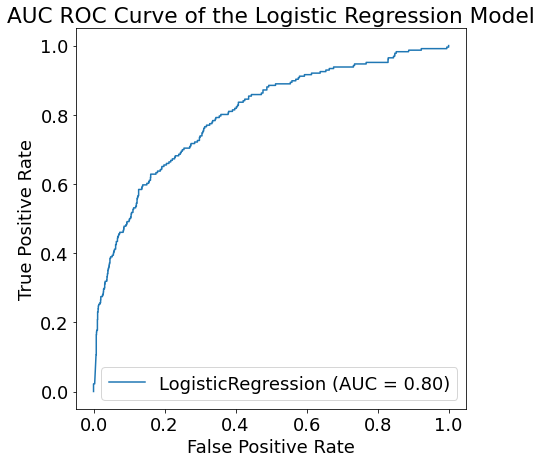

In [ ]:
fig, ax =  plt.subplots(figsize=(7, 7))
ax.set_title('AUC ROC Curve of the Logistic Regression Model')
plot_roc_curve(selected_model, valid_xs, valid_y, ax=ax);

# Predict on the test set

In [ ]:
test_df["prediction"] = selected_model.predict_proba(test_df[features].values)[:,1]

test_df["prediction"].to_csv("step2.csv", index=False)

## Interpret the model for knowledge discovery

Print the coefficients and intercept of the logistic regression model

In [ ]:
intercept = round(selected_model.intercept_[0],2)
print(f"The model intercept is {intercept}\n")

coefficients = [round(c,2) for c in selected_model.coef_[0]]

print("The model coefficients are:")
pd.DataFrame(coefficients, features, columns=['coef']).sort_values(by='coef', ascending=False)

The model intercept is -1.04

The model coefficients are:


,coef
پنالتی,2.10
ضربه آزاد مستقیم,1.22
کم,0.94
متوسط,0.66
مستقیم از کرنر,0.17
interveningTeammates,0.06
angle,0.02
پا,-0.08
distance,-0.09
interveningOpponents,-0.31


# Explicit Formula from Logistic Regression: </br>

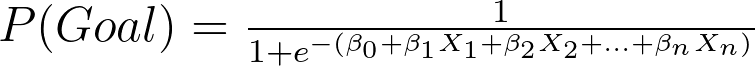

1-dimensional partial dependence plots

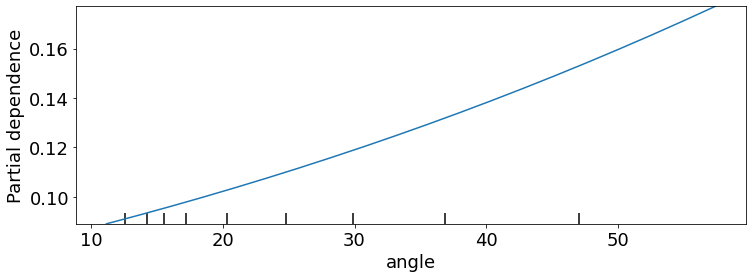

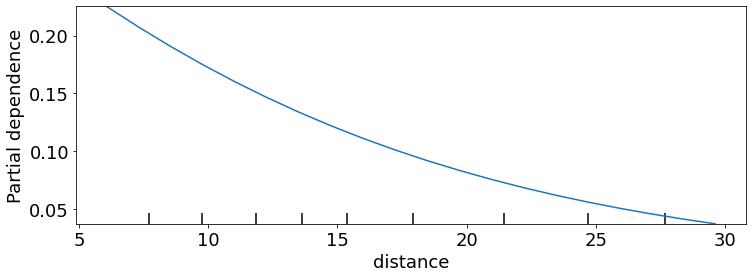

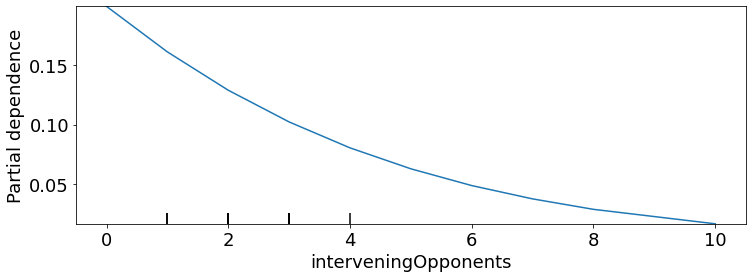

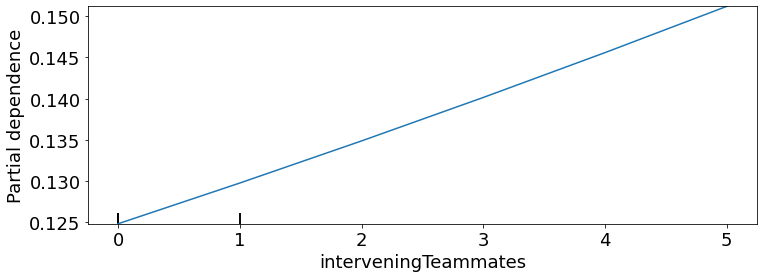

In [ ]:
explore_cols = ["angle", "distance", "interveningOpponents","interveningTeammates"]

valid_xs_df = pd.DataFrame(valid_xs, columns = features)

for index, col in enumerate(explore_cols):
    fig,ax = plt.subplots(figsize=(12, 4))
    plot_partial_dependence(selected_model, valid_xs_df, [col], grid_resolution=20, ax=ax);

2-dimensional partial dependence plots


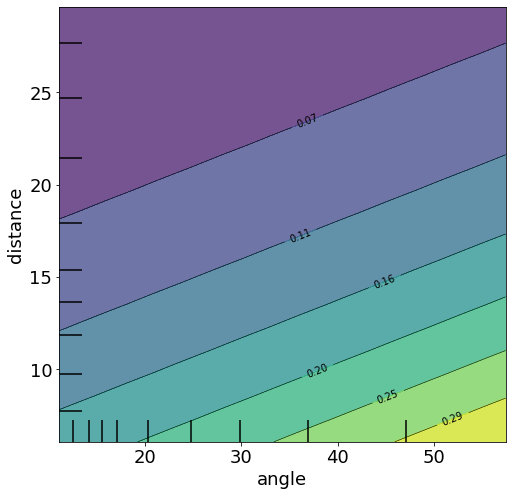

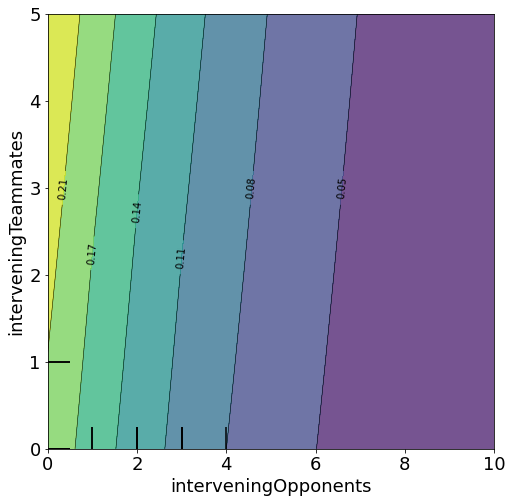

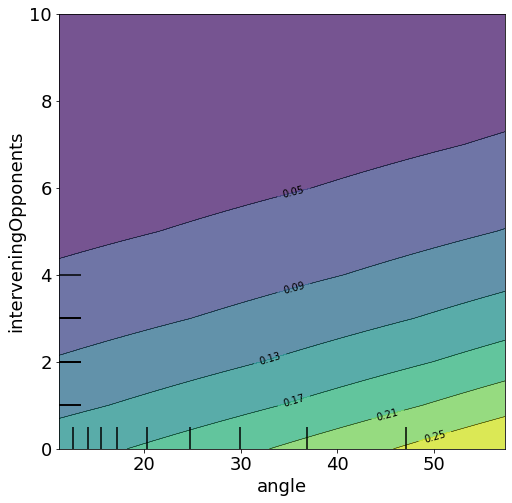

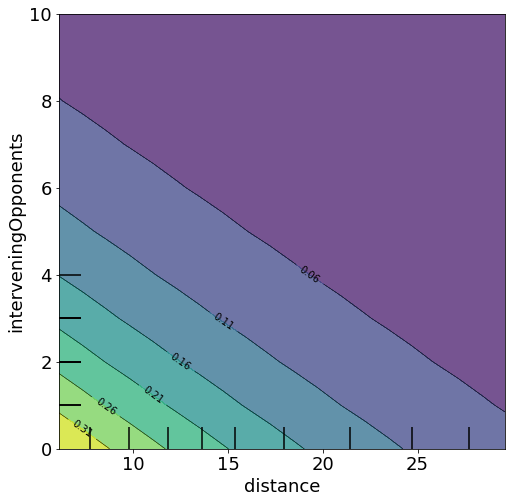

In [ ]:
paired_features = [
                  ("angle","distance"),
                  ("interveningOpponents","interveningTeammates"),
                  ("angle","interveningOpponents"),
                  ("distance","interveningOpponents"),
                  ]

for index, pair in enumerate(paired_features):
  fig,ax = plt.subplots(figsize=(8, 8))
  plot_partial_dependence(selected_model, valid_xs_df, [pair], grid_resolution=20, ax=ax);

# **Step 3 - Player Recruitment**

In [ ]:
# add the xG column
df["xG"] = selected_model.predict_proba(df[features].values)[:,1]

In [ ]:
# non-penalty goals
non_penalty_df = df.loc[df["پنالتی"]==0]

non_penalty_df["n_shots"] = 1

players_stats = non_penalty_df.groupby('playerId')[['n_shots', dep_var, 'xG']].sum().reset_index()

players_stats = players_stats.rename(columns={dep_var: "Goals"})

# calculate the number of matches they played
n_matches_dict = non_penalty_df.groupby("playerId")["matchId"].nunique().to_dict()

players_stats["n_matches"] = players_stats["playerId"].apply(lambda playerId: n_matches_dict[playerId])

players_stats["Outperformance1"] = players_stats["Goals"]/players_stats["xG"]

players_stats["Outperformance2"] = (players_stats["Goals"]-players_stats["xG"])/players_stats["n_matches"]

players_stats = players_stats.round(2)

ordered_cols = ['playerId','n_matches','n_shots','Goals','xG','Outperformance1','Outperformance2']

In [ ]:
players_stats[ordered_cols].sort_values("Goals",ascending=False).head(5)

,playerId,n_matches,n_shots,Goals,xG,Outperformance1,Outperformance2
70,p_18,53,62,15,8.21,1.83,0.13
116,p_6,53,63,13,7.38,1.76,0.11
73,p_20,59,68,12,9.05,1.33,0.05
18,p_115,57,62,12,9.58,1.25,0.04
72,p_2,50,58,12,8.15,1.47,0.08


In [ ]:
players_stats[ordered_cols].sort_values("xG",ascending=False).head(5)

,playerId,n_matches,n_shots,Goals,xG,Outperformance1,Outperformance2
0,p_1,61,66,9,10.60,0.85,-0.03
67,p_16,56,65,8,9.72,0.82,-0.03
18,p_115,57,62,12,9.58,1.25,0.04
105,p_5,54,62,8,9.56,0.84,-0.03
73,p_20,59,68,12,9.05,1.33,0.05


In [ ]:
players_stats[ordered_cols].sort_values("Outperformance1",ascending=False).head(5)

,playerId,n_matches,n_shots,Goals,xG,Outperformance1,Outperformance2
140,p_81,42,47,9,4.59,1.96,0.11
7,p_105,46,56,11,5.90,1.87,0.11
99,p_44,42,49,11,5.90,1.87,0.12
70,p_18,53,62,15,8.21,1.83,0.13
116,p_6,53,63,13,7.38,1.76,0.11


In [ ]:
players_stats[ordered_cols].sort_values("Outperformance2",ascending=False).head(5)

,playerId,n_matches,n_shots,Goals,xG,Outperformance1,Outperformance2
70,p_18,53,62,15,8.21,1.83,0.13
99,p_44,42,49,11,5.90,1.87,0.12
140,p_81,42,47,9,4.59,1.96,0.11
116,p_6,53,63,13,7.38,1.76,0.11
7,p_105,46,56,11,5.90,1.87,0.11


# **Step 4 - Match Analysis**

## Functions needed to enrich the Metrica Shots based on xG model features (Step 1)


In [ ]:
def calc_interferenceOnShooter(event_team, event_player, frame_home, frame_away):
  id_range = range(1,15)
  
  if event_team == home_team:
    opp_team_frame = frame_away
    event_team_frame = frame_home
    id_range = range(15,27)
    opp_team = away_team
  else:
    opp_team_frame = frame_home
    event_team_frame = frame_away
    opp_team = home_team

  cols = [[f"{opp_team}_{id}_x",f"{opp_team}_{id}_y"] for id in id_range]

  # ball carrier
  ballCarrier = tuple(event_team_frame[[f"{event_team}_{event_player}_x",f"{event_team}_{event_player}_y"]])

  number_of_pressing_players = 0
  for col in cols:
    oppPlayer = tuple(opp_team_frame[col])
    if calc_distance(ballCarrier, oppPlayer) <= 1:
      number_of_pressing_players = number_of_pressing_players + 1
  
  if number_of_pressing_players == 0:
    return 'کم'
  elif number_of_pressing_players == 1:
    return 'متوسط'
  else:
    return 'زیاد'

def calc_distance(point1, point2):
  """Euclidean distance between two points"""
  p1_x, p1_y = point1
  p2_x, p2_y = point2
  
  return np.sqrt((p1_x - p2_x)**2 + (p1_y - p2_y)**2)


def calc_distance_to_goalCenter(ball, event_team):
  """Euclidean distance to center of the target goal"""
  ball_x, ball_y = ball
  if event_team == home_team:
    return np.sqrt((ball_x - (-pitch_x/2))**2 + (ball_y)**2)
  else:
    return np.sqrt((ball_x - (pitch_x/2))**2 + (ball_y)**2)

def calc_angle(ball, event_team):
  """Shot angle to the goalposts in degrees"""
  ball_x, ball_y = ball

  x_distance_to_goal = abs(pitch_x/2 - ball_x)
  y_distance_to_goal = abs(ball_y)
  
  if event_team == home_team:
    x_distance_to_goal = abs(ball_x + pitch_x/2)
  angle =  np.arctan(goal_line_width*x_distance_to_goal/(x_distance_to_goal**2+y_distance_to_goal**2-(goal_line_width/2)**2))
  if angle < 0:
    angle = np.pi + angle
  return np.rad2deg(angle)

def calc_playType(event_pre_Type, event_pre_Subtype):
  '''Calculate the play type of a shot'''
  # Possible playTypes from xg model ['Open Play', 'Direct freekick', 'Penalty', 'Direct corner']
  play_type = "Open Play"
  if event_pre_Type == "SET PIECE":
    if event_pre_Subtype in ["FREE KICK","FREE KICK-RETAKEN"]:
      play_type = "ضربه آزاد مستقیم"
    elif event_pre_Subtype == "CORNER KICK":
      play_type = "مستقیم از کرنر"
    elif event_pre_Subtype == "PENALTY":
      play_type = "پنالتی"
  return play_type

def calc_BodyPart(event_Subtype):
  '''Calculate the body type involved in a shot'''
  # Assuming all shots are with either head or foot
  if "HEAD" in event_Subtype:
    return "سر"
  else:
    return "پا"

def calc_trianlge_area(point1, point2, point3):
  """Calculate a triangle area with three given points (x,y)"""

  x1, y1 = point1
  x2, y2 = point2
  x3, y3 = point3

  return abs((x1*(y2-y3)+(x2*(y3-y1))+(x3*(y1-y2)))/2)

def calc_Number_Intervening(ball, event_player, event_team, frame, frame_team_name):
  """Calculate whether a player lies inside the triangle between the shooter and the goalposts"""

  number_intervening_players = 0
  
  goalpost1 = ()
  goalpost2 = ()
  
  if event_team == home_team:
    goalpost1 = (-pitch_x/2, goal_line_width/2)
    goalpost2 = (-pitch_x/2, -goal_line_width/2)
  else:
    goalpost1 = (pitch_x/2, goal_line_width/2)
    goalpost2 = (pitch_x/2, -goal_line_width/2)

  shooter_triangle_area = calc_trianlge_area(ball, goalpost1, goalpost2)

  id_range = range(1,15)
  if frame_team_name == away_team:
    id_range = range(15,27)
  
  cols = [[f"{frame_team_name}_{id}_x",f"{frame_team_name}_{id}_y"] for id in id_range]

  # If calculating teammates obscuring the goal, remove the action taker player from the list
  if event_team == frame_team_name:
    cols.remove([f"{frame_team_name}_{event_player}_x",f"{frame_team_name}_{event_player}_y"])

  for col in cols:
    playerPoint = tuple(frame[col])
    if np.isnan(playerPoint[0]):
      continue
    player_triangles_areas = calc_trianlge_area(playerPoint, goalpost1, goalpost2) + calc_trianlge_area(playerPoint, goalpost1, ball) + calc_trianlge_area(playerPoint, goalpost2, ball)
    if round(shooter_triangle_area) == round(player_triangles_areas):
      number_intervening_players = number_intervening_players + 1
  return number_intervening_players

def calc_goal(event_Subtype):
  '''Calculate whether the outcome is goal or not'''
  if 'GOAL' in event_Subtype:
    return 1
  else:
    return 0

def calc_xG(instance):
  '''Predict the goal-scoring probability of a shot by applying the trained model'''
  x = instance[features].values.reshape(1,-1)
  return round(selected_model.predict_proba(x)[:,1][0],2)

## Find the shot frames and enrich them with defined functions to predict xG values.

In [ ]:
# Read the event data
events = mio.read_event_data(DATADIR,game_id)

# Bit of housekeeping: unit conversion from metric data units to meters
events = mio.to_metric_coordinates(events)

#### TRACKING DATA ####

# READING IN TRACKING DATA
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters 
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)

# Reverse direction of play in the second half 
# So that home team is always attacking from right->left
# And the away team is always attacking from left->right
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Add a column event 'Minute' to the data frame
events['Minute'] = events['Start Time [s]']/60.

# Add information abou the previous action
events["pre_Type"] = events["Type"].shift(1)
events["pre_Subtype"] = events["Subtype"].shift(1)

# Create the dataframe required by the xG model
xg_features = ['interveningOpponents', 'interveningTeammates', 'distance', 'angle', 
               'ضربه آزاد مستقیم', 'مستقیم از کرنر', 'پنالتی', 'سر', 'پا', 'متوسط', 'کم', 'isGoal']

instances = []
for index, event in events[events.Type=="SHOT"].iterrows():
  # Extract required information
  event_team = event.Team
  event_player = event.From.replace("Player","").strip()
  event_time_seconds = event["Start Time [s]"]
  event_time_minutes = event.Minute
  event_Subtype = event.Subtype
  event_pre_Type = event.pre_Type
  event_pre_Subtype = event.pre_Subtype

  frame_number = event["Start Frame"] # get the event frame number
  frame_home = tracking_home.loc[frame_number]
  frame_away = tracking_away.loc[frame_number]

  ball = (frame_home["ball_x"], frame_home["ball_y"])

  instance = {}
  instance["Frame"] = frame_number
  instance["team"] = event_team
  instance["Start Time [s]"] =  event_time_seconds
  instance["Minute"] = event_time_minutes

  if event_team == home_team:
    instance["interveningOpponents"] = calc_Number_Intervening(ball, event_player, event_team, frame_away, away_team)
    instance["interveningTeammates"] = calc_Number_Intervening(ball, event_player, event_team, frame_home, home_team)
  elif event_team == away_team:
    instance["interveningOpponents"] = calc_Number_Intervening(ball, event_player, event_team, frame_home, home_team)
    instance["interveningTeammates"] = calc_Number_Intervening(ball, event_player, event_team, frame_away, away_team)

  instance["distance"] = calc_distance_to_goalCenter(ball, event_team)
  instance["angle"] = calc_angle(ball, event_team)
  instance["bodyPart"] = calc_BodyPart(event_Subtype)  
  instance["playType"] = calc_playType(event_pre_Type, event_pre_Subtype)
  instance["interferenceOnShooter"] = calc_interferenceOnShooter(event_team, event_player, frame_home, frame_away)
  instance[dep_var] = calc_goal(event_Subtype)
  instances.append(instance)

instances_df = pd.DataFrame(instances)
instances_df = instances_df.round(2)

# Perform one-hot encoding
columns_to_encode = ["playType","bodyPart","interferenceOnShooter"]
for col in columns_to_encode:
  # Prevent multicollinearity
  one_hot = pd.get_dummies(instances_df[col])
  # Drop the column as it is now encoded
  instances_df = instances_df.drop(col,axis = 1)
  # Join the encoded df
  instances_df = instances_df.join(one_hot)

instances_df['مستقیم از کرنر'] = 0

# Move outcome to the last column
instances_df = instances_df[[x for x in instances_df.columns if x not in [dep_var]] + [dep_var]]

## Output Expected Goals
instances_df['xG'] = instances_df.apply(lambda instance: calc_xG(instance), axis=1)

display(instances_df.head())

Reading team: home
Reading team: away


,Frame,team,Start Time [s],Minute,interveningOpponents,interveningTeammates,distance,angle,Open Play,ضربه آزاد مستقیم,پنالتی,سر,پا,متوسط,کم,مستقیم از کرنر,isGoal,xG
0,4419,Home,176.76,2.95,3,0,22.60,10.82,1,0,0,0,1,0,1,0,0,0.05
1,12202,Home,488.08,8.13,1,0,6.07,58.85,1,0,0,0,1,1,0,0,1,0.45
2,16484,Home,659.36,10.99,2,0,15.76,18.88,1,0,0,0,1,0,1,0,0,0.13
3,18515,Away,740.60,12.34,1,1,23.57,15.98,1,0,0,0,1,0,1,0,0,0.09
4,27345,Home,1093.80,18.23,1,0,10.45,33.51,1,0,0,1,0,0,1,0,0,0.15


In [ ]:
instances_df.groupby("team")[dep_var, "xG"].sum()

,isGoal,xG
team,,
Away,2,2.81
Home,3,2.36


In [ ]:
# Binning xG

def calc_xg_quality(xg):
  if xg < 0.07:
    return "poor"
  elif 0.07 <= xg < 0.15:
    return "fair"
  elif 0.15 <= xg < 0.30:
    return "good"
  elif 0.30 <= xg:
    return "very good"

instances_df["xG_quality"] = instances_df["xG"].apply(lambda xg: calc_xg_quality(xg))
instances_df.groupby("team")["xG_quality"].value_counts()

team  xG_quality
Away  good          4
      very good     3
      fair          2
      poor          2
Home  fair          5
      very good     4
      poor          3
      good          1
Name: xG_quality, dtype: int64

In [ ]:
# inspird from plot_events in Metrica_Viz
def plot_xG(events, MarkerSize, color, figax=None, field_dimen = (105.0,68.0)):
    """ plot_events( events )
    
    Plots xG shots on a football pitch. event data can be a single or several rows of a data frame. All distances should be in meters.
    
    Parameters
    -----------
        events: row (i.e. instant) of the home team tracking data frame
        MarkerSize: marker size
        color: color of indicator
        fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot, 
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (105,68)
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """

    if figax is None: # create new pitch 
        fig,ax = mviz.plot_pitch( field_dimen = field_dimen )
    else: # overlay on a previously generated pitch
        fig,ax = figax 
    for i,row in events.iterrows():
          ax.plot( row['Start X'], row['Start Y'], color+'o', alpha=0.5, MarkerSize = MarkerSize)
    return fig,ax

Plot the shots with their xG values

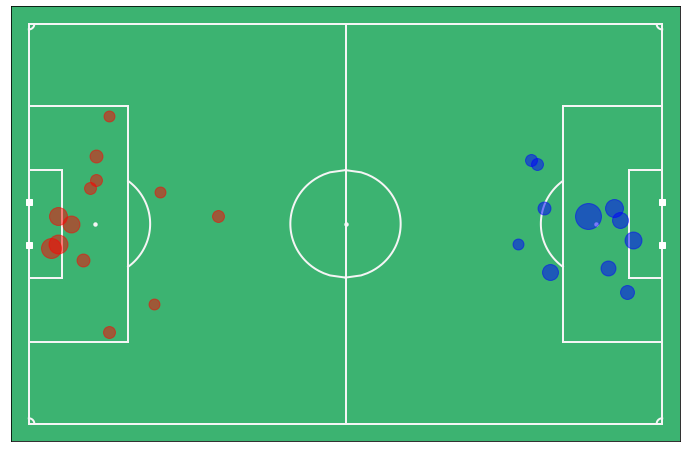

In [ ]:
figax = None
for index, instance in instances_df.iterrows():
  frame_id = instance["Frame"]
  team = instance["team"]
  xG = instance["xG"]
  color = 'r'
  if team == away_team:
    color = 'b'
  MarkerSize= math.ceil(xG*20) + 10
  fig,ax = plot_xG(events[(events.Type=="SHOT")&(events["Start Frame"]==frame_id)].iloc[-1:], MarkerSize=MarkerSize, color = color, figax=figax)
  figax = (fig,ax)

## Explore Cases

In [ ]:
instances_df.sort_values(by=["xG"])

,Frame,team,Start Time [s],Minute,interveningOpponents,interveningTeammates,distance,angle,Open Play,ضربه آزاد مستقیم,پنالتی,سر,پا,متوسط,کم,مستقیم از کرنر,isGoal,xG,xG_quality
5,29754,Home,1190.16,19.84,3,0,25.39,13.83,1,0,0,0,1,0,1,0,0,0.04,poor
0,4419,Home,176.76,2.95,3,0,22.60,10.82,1,0,0,0,1,0,1,0,0,0.05,poor
19,121027,Home,4841.08,80.68,2,0,22.93,17.66,1,0,0,0,1,1,0,0,1,0.05,poor
9,64772,Away,2590.88,43.18,3,1,24.21,16.99,1,0,0,0,1,0,1,0,0,0.05,poor
11,69887,Away,2795.48,46.59,2,0,24.58,15.25,1,0,0,0,1,0,1,0,0,0.06,poor
23,139891,Home,5595.64,93.26,3,0,31.11,13.40,0,1,0,0,1,0,1,0,0,0.07,fair
18,117218,Home,4688.72,78.15,2,0,14.01,23.45,1,0,0,1,0,0,1,0,0,0.07,fair
10,67067,Home,2682.68,44.71,1,0,22.64,11.07,1,0,0,0,1,0,1,0,0,0.08,fair
3,18515,Away,740.60,12.34,1,1,23.57,15.98,1,0,0,0,1,0,1,0,0,0.09,fair
7,56079,Home,2243.16,37.39,2,0,12.55,28.47,1,0,0,1,0,0,1,0,0,0.09,fair


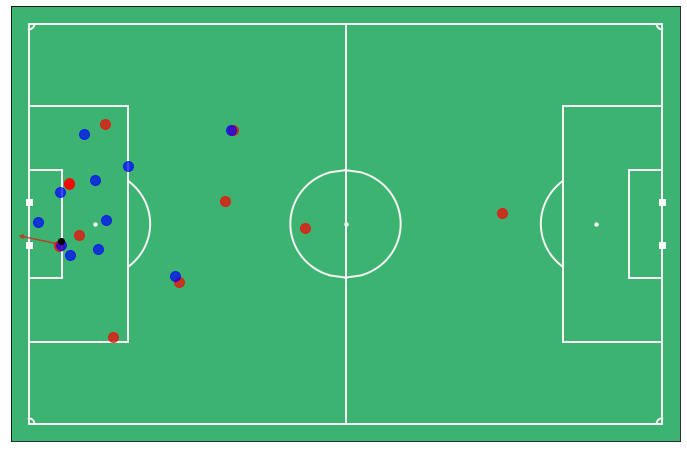

In [ ]:
# Plot a shot taken by the Home team
frame_id = 12202
fig,ax = mviz.plot_events(events[(events.Type=="SHOT")&(events["Start Frame"]==frame_id)].iloc[-1:], indicators = ['Marker','Arrow'], annotate=False, field_dimen = (105.0,68.0))
fig,ax = mviz.plot_frame(tracking_home.loc[frame_id], tracking_away.loc[frame_id], field_dimen = (105.0,68.0), figax = (fig,ax) )

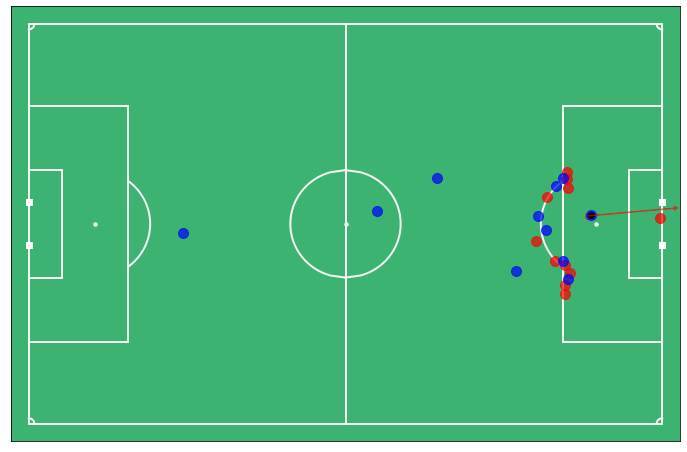

In [ ]:
# Plot a shot taken by the Away team
frame_id = 115009
fig,ax = mviz.plot_events(events[(events.Type=="SHOT")&(events["Start Frame"]==frame_id)].iloc[-1:], indicators = ['Marker','Arrow'], annotate=False, field_dimen = (105.0,68.0))
fig,ax = mviz.plot_frame(tracking_home.loc[frame_id], tracking_away.loc[frame_id], field_dimen = (105.0,68.0), figax = (fig,ax) )

## THE END!